# Polygon Simplification

This guide demonstrates customizing polygon requests to simplify the geometry of the returned polygons.

Contrails API supports both [GeoJSON](https://geojson.org/) and [KML](https://developers.google.com/kml/documentation/kmlreference) polygon formats. We only work with GeoJSON polygons in this notebook.

This notebook uses [Shapely](https://shapely.readthedocs.io/en/latest/index.html) to interact with polygons. In particular, [GEOS](https://shapely.readthedocs.io/en/latest/reference/shapely.from_geojson.html) is required to convert GeoJSON to Shapely polygons.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/contrailcirrus/2023-04-pycontrails-workshop/blob/main/notebooks/04-API-Polygons.ipynb)

In [ ]:
!pip install shapely
!pip install matplotlib
!pip install pandas
!pip install requests

In [1]:
import json
import os
from pprint import pprint

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import pandas as pd
import requests
import shapely

In [2]:
# Define credentials
URL = "https://api.contrails.org/v0"
api_key = "ADD API KEY"
headers = {"x-api-key": api_key}

# Confirm credentials are valid
r = requests.get(f"{URL}/auth/validate-key", headers=headers)
print(f"HTTP Response Code: {r.status_code} {r.reason}")

HTTP Response Code: 200 OK


## Query parameters

The following query parameters are used in the [/grid/cocip](https://api.contrails.org/openapi#/Grid/contrail_cirrus_predictions_v0_grid_cocip_get) endpoint:

- `time`: The time for the polygon prediction. Must be an ISO 8601 datetime string or unix timestamp (seconds since epoch).
- `format`: Set `format=geojson` to return polygons in GeoJSON format.
- `aircraft_type`: Specify an [aircraft type](https://apidocs.contrails.org/notebooks/get_started.html#id2) for the polygon prediction.
- `threshold`: The energy forcing threshold for the polygon boundary. See [our reference](https://apidocs.contrails.org/ef_interpretation.html) for more information.
- `interiors`: Set `interiors=true` to return [interior polygons](#Interior-polygons).
- `simplify`: Used to control the extent to which polygon [geometry is simplified](#The-simplify-query-parameter).
- `convex_hull`: Set `convex_hull=true` to return the [convex hull](#Experimental:-convex-hulls) of the polygon.
- `bbox`: Used to downselect horizontally.
- `flight_level`: Used to downselect vertically.

## Default parameters

Here, we request CoCiP polygons at a single flight level using the default polygon simplify parameters.

> The `flight_level` query parameter was added in version 0.14.0.

In [3]:
params = {
    "time": "2023-02-10",
    "aircraft_type": "A320",
    "threshold": 1e8,
    "format": "geojson",
    "flight_level": 360,
}

r = requests.get(f"{URL}/grid/cocip", params=params, headers=headers)
print(f"HTTP Response Code: {r.status_code} {r.reason}")

HTTP Response Code: 200 OK


In [4]:
geojson = r.json()
feature = geojson["features"][0]

# Print out the metadata
pprint(feature["properties"])

# Convert the output to shapely
# Unfortunately, GEOS can't handle the altitude coordinate returned by the API
# Manually loop through and remove it
for coords in feature["geometry"]["coordinates"]:
    for poly in coords:
        for point in poly:
            del point[2]

multipoly = shapely.from_geojson(json.dumps(feature))

{'aircraft_type': 'A320',
 'cocip_dt_integration': '5 minutes',
 'cocip_max_contrail_age': '12 hours',
 'humidity_scaling_formula': 'rhi -> (rhi / rhi_adj) ^ rhi_boost_exponent',
 'humidity_scaling_name': 'exponential_boost_latitude_customization',
 'level': 360,
 'level_long_name': 'Flight Level',
 'level_standard_name': 'FL',
 'level_units': 'hectofeet',
 'long_name': 'Energy forcing per meter of flight trajectory',
 'met_source': 'ERA5',
 'name': 'ef_per_m',
 'polygon_iso_value': 100000000.0,
 'pycontrails_version': '0.32.2',
 'time': '2023-02-10T00:00:00Z',
 'units': 'J / m'}


### Polygon topology

GeoJSON polygons have both interior and exterior boundaries. Below use red for exterior boundaries and blue for interior boundaries.

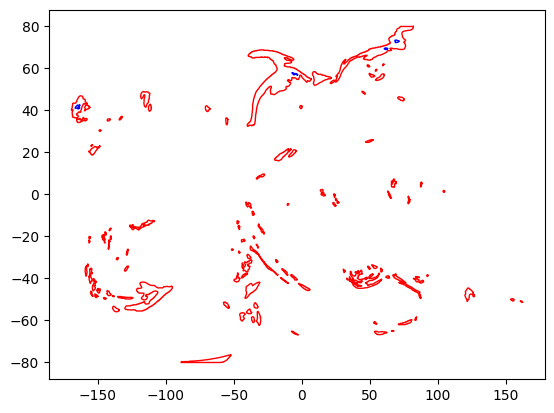

In [5]:
for poly in multipoly.geoms:
    plt.plot(*poly.exterior.xy, color="red", lw=1)
    for interior in poly.interiors:
        plt.plot(*interior.xy, color="blue", lw=1)

In [6]:
# Print some statistics on the polygons
n_exterior_rings = len(multipoly.geoms)
n_interior_rings = sum(len(p.interiors) for p in multipoly.geoms)
n_exterior_vertices = sum(len(p.exterior.coords) for p in multipoly.geoms)
n_interior_vertices = sum(len(i.coords) for p in multipoly.geoms for i in p.interiors)
area = multipoly.area

print(f"Number of exterior rings: {n_exterior_rings}")
print(f"Number of interior rings: {n_interior_rings}")
print(f"Number of exterior vertices: {n_exterior_vertices}")
print(f"Number of interior vertices: {n_interior_vertices}")
print(f"Total area: {area}")  # units are in the image of the Plate carree projection

Number of exterior rings: 123
Number of interior rings: 4
Number of exterior vertices: 3615
Number of interior vertices: 64
Total area: 1525.9174499999972


In [7]:
# Formalize some of cells above into functions for later use


def get_shapely(**kwargs):
    params = {
        "time": "2023-02-10",
        "aircraft_type": "A320",
        "threshold": 1e8,
        "format": "geojson",
        "flight_level": 360,
    }
    params.update(kwargs)

    r = requests.get(f"{URL}/grid/cocip", params=params, headers=headers)
    r.raise_for_status()

    geojson = r.json()
    (feature,) = geojson["features"]

    for coords in feature["geometry"]["coordinates"]:
        for poly in coords:
            for point in poly:
                del point[2]

    return shapely.from_geojson(json.dumps(feature))


def polygon_metrics(multipoly):
    n_exterior_rings = len(multipoly.geoms)
    n_interior_rings = sum(len(p.interiors) for p in multipoly.geoms)
    n_exterior_vertices = sum(len(p.exterior.coords) for p in multipoly.geoms)
    n_interior_vertices = sum(len(i.coords) for p in multipoly.geoms for i in p.interiors)
    area = multipoly.area
    return {
        "n_exterior_rings": n_exterior_rings,
        "n_interior_rings": n_interior_rings,
        "n_exterior_vertices": n_exterior_vertices,
        "n_interior_vertices": n_interior_vertices,
        "area": area,
    }

## Interior polygons

Set the query parameter `interiors=false` to only return exterior polygons.

As seen in the `polygon_metrics` output and in the plot, the exterior polygons remain the same as before, but the interior polygons are removed.

{'n_exterior_rings': 123, 'n_interior_rings': 0, 'n_exterior_vertices': 3615, 'n_interior_vertices': 0, 'area': 1534.6521499999974}


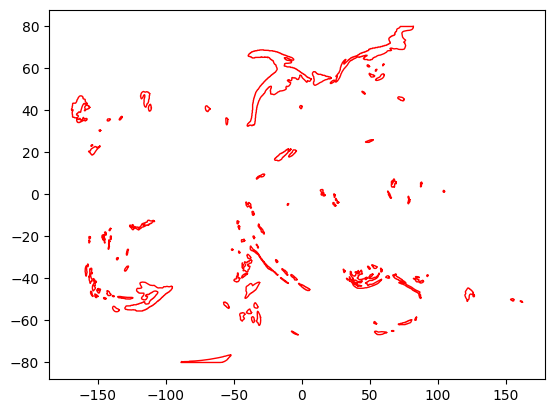

In [8]:
multipoly = get_shapely(interiors=False)

print(polygon_metrics(multipoly))

for poly in multipoly.geoms:
    plt.plot(*poly.exterior.xy, color="red", lw=1)
    assert len(poly.interiors) == 0

## The `simplify` query parameter

Use the `simplify` query parameter to customize the extent to which polygon boundaries are simplified. This parameter is an integer between 0 and 10, inclusive. A value of 0 means no simplification. A value of 10 simplifies aggressively (thereby introducing some error). The default value is 3. A higher value also drops more small polygons.

In [9]:
multipoly_list = [get_shapely(interiors=False, simplify=s) for s in range(0, 11)]

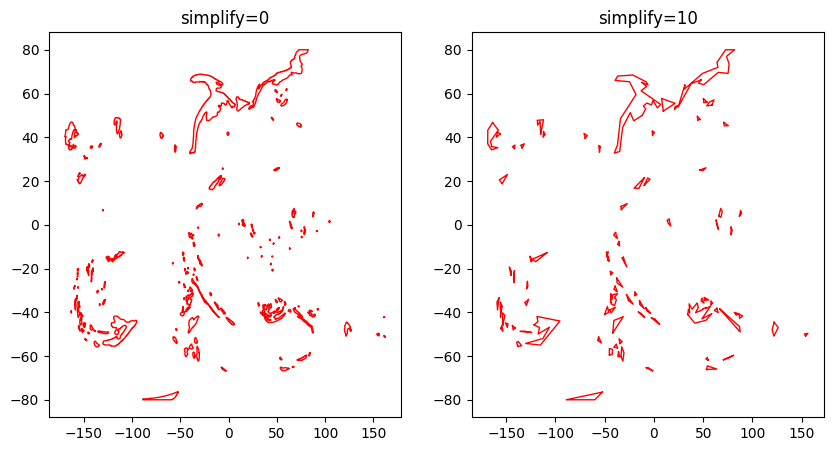

In [10]:
# Plot the least and most aggressively simplified polygons side by side

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_title("simplify=0")
multipoly = multipoly_list[0]
for poly in multipoly.geoms:
    ax1.plot(*poly.exterior.xy, color="red", lw=1)

ax2.set_title("simplify=10")
multipoly = multipoly_list[-1]
for poly in multipoly.geoms:
    ax2.plot(*poly.exterior.xy, color="red", lw=1)

### Metrics

Make a table showing how the number of polygons and vertices changes with different values of `simplify`.

In [11]:
df = pd.DataFrame([polygon_metrics(m) for m in multipoly_list])
df = df.rename_axis("simplify")
df

,n_exterior_rings,n_interior_rings,n_exterior_vertices,n_interior_vertices,area
simplify,,,,,
0,178,0,7929,0,1551.18190
1,153,0,5598,0,1547.04285
2,138,0,4530,0,1542.21925
3,123,0,3615,0,1534.65215
4,116,0,2818,0,1529.68535
5,108,0,1831,0,1530.40525
6,105,0,1209,0,1503.88170
7,100,0,862,0,1474.33200
8,97,0,641,0,1456.04050


### Visualize

Visualize how a few of the larger polygons vary with `simplify`.

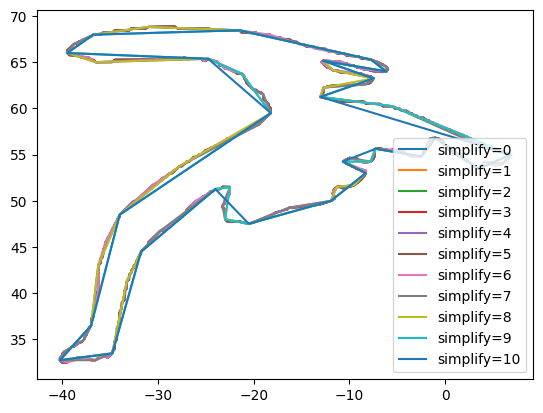

In [12]:
p0 = shapely.Point(-17, 50)

fig, ax = plt.subplots()
for i, multipoly in enumerate(multipoly_list):
    for p in multipoly.geoms:
        if p.contains(p0):
            ax.plot(*p.exterior.xy, label=f"simplify={i}")

ax.legend();

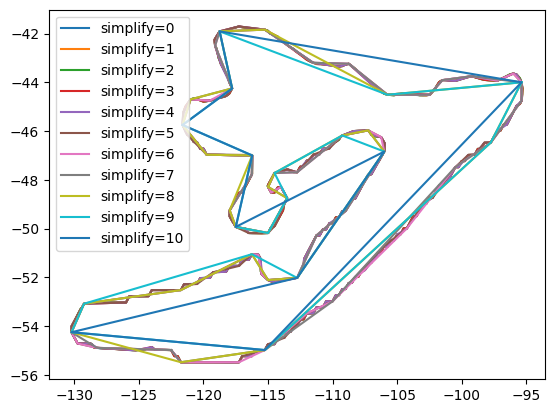

In [13]:
p0 = shapely.Point(-120, -54)

fig, ax = plt.subplots()
for i, multipoly in enumerate(multipoly_list):
    for p in multipoly.geoms:
        if p.contains(p0):
            ax.plot(*p.exterior.xy, label=f"simplify={i}")

ax.legend();

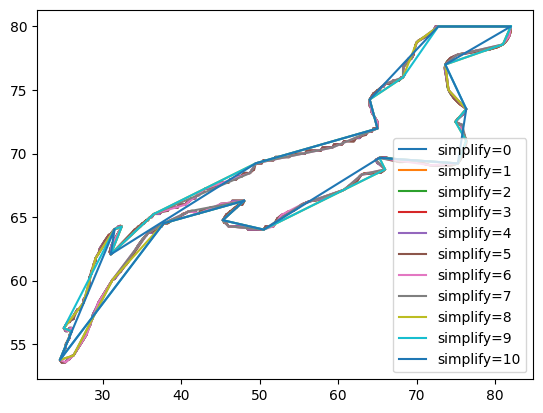

In [14]:
p0 = shapely.Point(55, 67)

fig, ax = plt.subplots()
for i, multipoly in enumerate(multipoly_list):
    for p in multipoly.geoms:
        if p.contains(p0):
            ax.plot(*p.exterior.xy, label=f"simplify={i}")

ax.legend();

## Experimental: convex hulls

Use the boolean `convex_hull` query parameter to simplify polygons by computing their convex hulls. This parameter is experimental (`false` by default). When this parameter is enabled, the `interiors` parameter is automatically set to `false`.

This purpose of this parameter is to:
- Further reduce the complexity of the polygon geometry.
- Fill in "fjords" and other gaps in the polygon geometry. If polygons are regions to be avoided, points outside of a polygon but inside its convex hull may still be inaccessible for trajectory planning. By explicitly taking a convex hull, the flight planner may have an easier time creating optimal trajectories.

As seen in the table below, the number of polygons (`n_exterior_rings`) and the number of vertices are reduced when using the `convex_hull` parameter. On the other hand, the total footprint of the polygons is increased (as measured by the `area` metric).

In [15]:
multipoly_list_ch = [get_shapely(convex_hull=True, simplify=s) for s in range(0, 11)]

In [16]:
df1 = (
    df.drop(columns=["n_interior_rings", "n_interior_vertices"])
    .assign(convex_hull=False)
    .rename_axis("simplify", axis=0)
    .set_index("convex_hull", append=True)
)

df2 = pd.DataFrame([polygon_metrics(m) for m in multipoly_list_ch])
df2 = (
    df2.drop(columns=["n_interior_rings", "n_interior_vertices"])
    .assign(convex_hull=True)
    .rename_axis("simplify", axis=0)
    .set_index("convex_hull", append=True)
)

df = pd.concat([df1, df2], axis=0)
df.sort_index()

n_exterior_rings  n_exterior_vertices        area
simplify convex_hull                                                   
0        False                     178                 7929  1551.18190
         True                      167                 2402  2977.02595
1        False                     153                 5598  1547.04285
         True                      145                 1923  2970.01715
2        False                     138                 4530  1542.21925
         True                      131                 1621  2953.64905
3        False                     123                 3615  1534.65215
         True                      117                 1290  2943.50030
4        False                     116                 2818  1529.68535
         True                      110                 1095  2933.04535
5        False                     108                 1831  1530.40525
         True                      102                  881  2911.46940
6        False                     105                 1209  1503.88170
         True                       99                  710  2879.05115
7        False                     100                  862  1474.33200
         True                       95                  555  2813.56410
8        False                      97                  641  1456.04050
         True                       92                  453  2716.37245
9        False                      92                  507  1390.00965
         True                       87                  395  2663.01390
10       False                      81                  401  1381.24940
         True                       77                  340  2635.26300

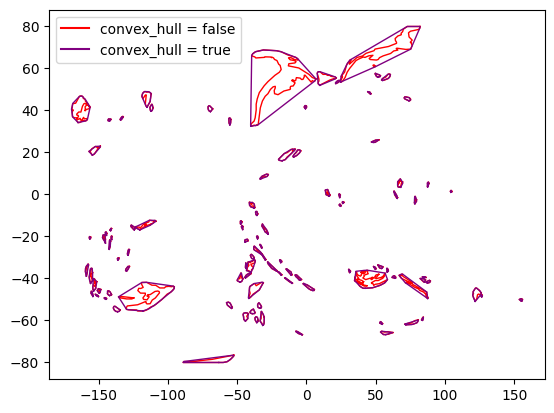

In [17]:
fig, ax = plt.subplots()

for poly in multipoly_list[6].geoms:
    ax.plot(*poly.exterior.xy, color="red", lw=1)

for poly in multipoly_list_ch[6].geoms:
    ax.plot(*poly.exterior.xy, color="purple", lw=1)

red_line = mlines.Line2D([], [], color="red", label="convex_hull = false")
purple_line = mlines.Line2D([], [], color="purple", label="convex_hull = true")
ax.legend(handles=[red_line, purple_line]);